<a href="https://colab.research.google.com/github/greyhound101/Data_Science_bowl-2019/blob/master/predicting_molecular_properties.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.environ['KAGGLE_USERNAME'] = "" # username from the json file
os.environ['KAGGLE_KEY'] = "" # key from the json file
!kaggle competitions download -c champs-scalar-coupling

  0% 0.00/386 [00:00<?, ?B/s]
100% 386/386 [00:00<00:00, 632kB/s]
  0% 0.00/385 [00:00<?, ?B/s]
100% 385/385 [00:00<00:00, 384kB/s]
  0% 0.00/168 [00:00<?, ?B/s]
100% 168/168 [00:00<00:00, 517kB/s]
  0% 0.00/470 [00:00<?, ?B/s]
100% 470/470 [00:00<00:00, 391kB/s]
  0% 0.00/299 [00:00<?, ?B/s]
100% 299/299 [00:00<00:00, 294kB/s]
  0% 0.00/128 [00:00<?, ?B/s]
100% 128/128 [00:00<00:00, 128kB/s]
  0% 0.00/341 [00:00<?, ?B/s]
100% 341/341 [00:00<00:00, 342kB/s]
  0% 0.00/212 [00:00<?, ?B/s]
100% 212/212 [00:00<00:00, 212kB/s]
  0% 0.00/382 [00:00<?, ?B/s]
100% 382/382 [00:00<00:00, 365kB/s]
  0% 0.00/254 [00:00<?, ?B/s]
100% 254/254 [00:00<00:00, 246kB/s]
  0% 0.00/257 [00:00<?, ?B/s]
100% 257/257 [00:00<00:00, 209kB/s]
  0% 0.00/255 [00:00<?, ?B/s]
100% 255/255 [00:00<00:00, 257kB/s]
  0% 0.00/385 [00:00<?, ?B/s]
100% 385/385 [00:00<00:00, 198kB/s]
  0% 0.00/297 [00:00<?, ?B/s]
100% 297/297 [00:00<00:00, 293kB/s]
  0% 0.00/171 [00:00<?, ?B/s]
100% 171/171 [00:00<00:00, 150kB/s]
  0% 0.00/

In [3]:
from tqdm import tqdm
import pandas as pd
import numpy as np
struc=pd.read_csv("structures.csv.zip")
atomic_radius = {'H':0.43, 'C':0.82, 'N':0.80, 'O':0.78, 'F':0.76} # With fudge factor
atoms = struc['atom'].values
atoms_rad = [atomic_radius[x] for x in tqdm(atoms)]
struc["rad"]=atoms_rad
vals=struc[["x","y","z","rad"]].values
from numba import jit
from statistics import mean
nms=struc.groupby(["molecule_name"]).size().cumsum().values
ln=len(nms)
a=np.zeros(ln+1,dtype=int)
a[1:]=nms
from math import sqrt
@jit
def atm(id):
    start=a[id]
    stop=a[id+1]
    locs=vals[start:stop,:]
    num_atoms=stop-start
    dmat=np.zeros((num_atoms,num_atoms))
    bnds=np.zeros((num_atoms,28))
    for i in range(num_atoms):
        for j in range(i+1, num_atoms):
            d = sqrt((locs[i,0] - locs[j,0])**2 + (locs[i,1] - locs[j,1])**2 + (locs[i,2] - locs[j,2])**2)
            dmat[i,j] = d
            dmat[j,i] = d
            tot_rad=locs[i,3]+locs[j,3]
            if d<tot_rad:
                bnds[i,j]=d
                bnds[j,i]=d
    x=np.zeros(num_atoms)
    for i in range(num_atoms):
        y=bnds[i]
        y=y[np.where(y>0)]
        x[i]=np.mean(y)
    return dmat,num_atoms,locs[:,:3],x
def sml(id):
    dmat,num,locs,x=atm(id)
    smll=[]
    dmat[dmat==0]=10
    idx=[]
    ret=np.zeros((num,5))
    for i in range(num):
        idx.append(np.argmin(dmat[i]))
        smll.append(dmat[i][np.argmin(dmat[i])])
    for j,i in enumerate(idx):
        ret[j,:3]=locs[i]
    ret[:,3]=smll
    ret[:,4]=x
    return ret,num
from tqdm import tqdm
def fnal(df):
    df["x_c"]=df.groupby("molecule_name")["x"].transform("mean")
    df["z_c"]=df.groupby("molecule_name")["z"].transform("mean")
    df["y_c"]=df.groupby("molecule_name")["y"].transform("mean")
    ret=np.zeros((struc.shape[0],5))
    for i in tqdm(range(len(df["molecule_name"].unique()))):
        sm,nm=sml(i)
        ret[a[i]:a[i+1],:5]=sm
        
    return ret

retu=fnal(struc)
fina=pd.DataFrame(retu,columns=["x_nr","y_nr","z_nr","dis_nr","bond"])
struc=pd.concat([struc,fina],1)
trn=pd.read_csv("train.csv.zip")
tst=pd.read_csv("test.csv.zip")
trn=trn.merge(struc,how="left",left_on=["molecule_name","atom_index_0"],right_on=["molecule_name","atom_index"])
trn=trn.merge(struc,how="left",left_on=["molecule_name","atom_index_1"],right_on=["molecule_name","atom_index"])


tst=tst.merge(struc,how="left",left_on=["molecule_name","atom_index_0"],right_on=["molecule_name","atom_index"])
tst=tst.merge(struc,how="left",left_on=["molecule_name","atom_index_1"],right_on=["molecule_name","atom_index"])
def typ(data):
    return int(data[0])
def cat(data):
    return data[1:]


trn["type_1"]=trn["type"].apply(typ)
trn["type_0"]=trn["type"].apply(cat)
tst["type_1"]=tst["type"].apply(typ)
tst["type_0"]=tst["type"].apply(cat)


id=tst["id"]
def dist(df):
    df["X"]=(df["x_x"]-df["x_y"])
    df["Y"]=(df["y_x"]-df["y_y"])
    df["Z"]=(df["z_x"]-df["z_y"])
    df["dis"]=(df["X"]**2+df["Y"]**2+df["Z"]**2)**0.5
    df["number"]=df["type"].apply(typ)
    df["cat"]=df["type"].apply(cat)
    df=df.drop(["atom_x"],1)
    
    return df
trn=dist(trn)
tst=dist(tst)
from sklearn.preprocessing import LabelEncoder
def lbl(trn,tst):
    
    cate=["atom_y","cat"]
    for i in cate:
        le=LabelEncoder()
        unq=list(trn[i].unique())+list(tst[i].unique())
        le.fit(unq)
        trn[i]=le.transform(trn[i])
        tst[i]=le.transform(tst[i])
    trn["number"]=trn["number"].astype("uint8")
    dtyp=tst.dtypes
    ls=list(tst)
    for j,i in enumerate(dtyp):
        if "int" in str(i):
            trn[ls[j]]=pd.to_numeric(trn[ls[j]],downcast="integer")
            tst[ls[j]]=pd.to_numeric(tst[ls[j]],downcast="integer")
        elif "float" in str(i):
            trn[ls[j]]=pd.to_numeric(trn[ls[j]],downcast="float")
            tst[ls[j]]=pd.to_numeric(tst[ls[j]],downcast="float")
    return trn,tst
trn,tst=lbl(trn,tst)


def angle(df):
    df["dis_c_x"]=((df["x_x"]-df["x_c_x"])**2+(df["y_x"]-df["y_c_x"])**2+(df["z_x"]-df["x_c_x"])**2)**0.5
    df["dis_n_x"]=((df["x_x"]-df["x_nr_x"])**2+(df["y_x"]-df["y_nr_x"])**2+(df["z_x"]-df["x_nr_x"])**2)**0.5
    df["dis_c_y"]=((df["x_y"]-df["x_c_y"])**2+(df["y_y"]-df["y_c_y"])**2+(df["z_y"]-df["x_c_y"])**2)**0.5
    df["dis_n_y"]=((df["x_y"]-df["x_nr_y"])**2+(df["y_y"]-df["y_nr_y"])**2+(df["z_y"]-df["x_nr_y"])**2)**0.5
    
    
    
    
    df["v_c_xx"]=df["x_x"]-df["x_c_x"]
    df["v_c_yx"]=df["y_x"]-df["y_c_x"]
    df["v_c_zx"]=df["z_x"]-df["z_c_x"]
    df["v_c_xy"]=df["x_y"]-df["x_c_y"]
    df["v_c_yy"]=df["y_y"]-df["y_c_y"]
    df["v_c_zy"]=df["z_y"]-df["z_c_y"]
    df["angle_c"]=((df["v_c_xx"]*df["v_c_xy"])+(df["v_c_yx"]*df["v_c_yy"])+(df["v_c_zx"]*df["v_c_zy"]))/(df["dis_c_x"]*df["dis_c_y"])
    df["angle_c0"]=((df["v_c_xx"]*df["X"])+(df["v_c_yx"]*df["Y"])+(df["v_c_zx"]*df["Z"]))/(df["dis_c_x"]*df["dis"])
    
    
    
    df["v_n_xx"]=df["x_x"]-df["x_nr_x"]
    df["v_n_yx"]=df["y_x"]-df["y_nr_x"]
    df["v_n_zx"]=df["z_x"]-df["z_nr_x"]
    df["v_n_xy"]=df["x_y"]-df["x_nr_y"]
    df["v_n_yy"]=df["y_y"]-df["y_nr_y"]
    df["v_n_zy"]=df["z_y"]-df["z_nr_y"]
    df["angle_n"]=((df["v_n_xx"]*df["v_n_xy"])+(df["v_n_yx"]*df["v_n_yy"])+(df["v_n_zx"]*df["v_n_zy"]))/(df["dis_n_x"]*df["dis_n_y"])
    df["angle_n0"]=((df["v_n_xx"]*df["X"])+(df["v_n_yx"]*df["Y"])+(df["v_n_zx"]*df["Z"]))/(df["dis_n_x"]*df["dis"])
    df["angle_n1"]=((df["X"]*df["v_n_xy"])+(df["Y"]*df["v_n_yy"])+(df["Z"]*df["v_n_zy"]))/(df["dis_n_y"]*df["dis"])
    
    
    
    
    df["c_n_0x"]=((df["v_n_xx"]*df["v_c_xx"])+(df["v_n_yx"]*df["v_c_yx"])+(df["v_n_zx"]*df["v_c_zx"]))/(df["dis_c_x"]*df["dis_n_x"])
    df["c_n_0y"]=((df["v_n_xy"]*df["v_c_xy"])+(df["v_n_yy"]*df["v_c_yy"])+(df["v_n_zy"]*df["v_c_zy"]))/(df["dis_c_y"]*df["dis_n_y"])
    
    
    
    
    
    
    
    df["v_n_c_xx"]=df["x_nr_x"]-df["x_c_x"]
    df["v_n_c_yx"]=df["y_nr_x"]-df["y_c_x"]
    df["v_n_c_zx"]=df["z_nr_x"]-df["z_c_x"]
    df["v_n_c_xy"]=df["x_nr_y"]-df["x_c_y"]
    df["v_n_c_yy"]=df["y_nr_y"]-df["y_c_y"]
    df["v_n_c_zy"]=df["z_nr_y"]-df["z_c_y"]
    df["ang_c_nx"]=((df["v_n_xx"]*df["v_c_xx"])+(df["v_n_yx"]*df["v_c_yx"])+(df["v_n_zx"]*df["v_c_zx"]))
    df["ang_c_ny"]=((df["v_n_xy"]*df["v_c_xy"])+(df["v_n_yy"]*df["v_c_yy"])+(df["v_n_zy"]*df["v_c_zy"]))
    return df

trn=angle(trn)
    
tst=angle(tst)
def dum(df):
    dumm=["type_1","type_0","type"]
    for i in dumm:
        df=pd.concat([df,pd.get_dummies(df[i])],1)
    df=df.drop(dumm,1)
    return df
trn=dum(trn)
tst=dum(tst)
    
dp=[
"v_n_xx","v_n_yx","v_n_zx","v_n_xy","v_n_yy","v_n_zy",
"v_c_xx","v_c_yx","v_c_zx","v_c_xy","v_c_yy","v_c_zy"]
trn=trn.drop(dp,1)
tst=tst.drop(dp,1)
def combo(df):
    df["x_near"]=(df["x_nr_x"]+df["x_nr_y"])/2
    df["y_near"]=(df["y_nr_x"]+df["y_nr_y"])/2
    df["z_near"]=(df["z_nr_x"]+df["z_nr_y"])/2
    
    
    
    
    
    df["x_center"]=(df["x_c_x"]+df["x_c_y"])/2
    df["y_center"]=(df["y_c_x"]+df["y_c_y"])/2
    df["z_center"]=(df["z_c_x"]+df["z_c_y"])/2
    return df
trn=combo(trn)
tst=combo(tst)
dp=["x_c_x","x_c_y","y_c_x","y_c_y","z_c_x","z_c_y",
       "x_nr_x","x_nr_y","y_nr_x","y_nr_y","z_nr_x","z_nr_y"]
trn=trn.drop(dp,1)
tst=tst.drop(dp,1)
id=tst["id"]
dp1=["id","molecule_name","atom_index_0","atom_index_1","x_x","y_x","z_x","x_y","y_y","z_y"]
trn=trn.drop(dp1,1)
tst=tst.drop(dp1,1)
def reduce(df):
    ls=list(df)
    for i,j in enumerate(df.dtypes):
        
        if "float" in str(j):
            df[ls[i]]=pd.to_numeric(df[ls[i]],downcast="float")
        if "int" in str(j):
            df[ls[i]]=pd.to_numeric(df[ls[i]],downcast="integer")
    return df
trn=reduce(trn)
tst=reduce(tst)
dp1=["v_n_c_yy","v_n_c_zy","v_n_c_xy","v_n_c_zx","v_n_c_yx","v_n_c_xx","v_n_c_zy","dis_n_y","dis_n_x"]
trn=trn.drop(dp1,1)
tst=tst.drop(dp1,1)
dps=["rad_x","rad_y","atom_index_y","atom_index_x","X","Y","Z","number","cat","dis_c_x","dis_c_y","angle_c","angle_c0"]
trn=trn.drop(dps,1)
tst=tst.drop(dps,1)
dp1=["x_near","y_near","z_near","x_center","y_center","z_center"]
trn=trn.drop(dp1,1)
tst=tst.drop(dp1,1)
import xgboost as xgb
pm={'cosample_by_tree': 0.3,
 'max_bins': 17,
 'max_depth': 26,
 'num_leaves': 215,
 'subsample': 0.7,
   "eval_metric":"mae"}
from sklearn.model_selection import train_test_split
x,x1,y,y1=train_test_split(trn.drop(["scalar_coupling_constant"],1),trn["scalar_coupling_constant"])
d1=xgb.DMatrix(data=x,label=y)
d2=xgb.DMatrix(data=x1,label=y1)
watchlist=[(d1,"train_data"),(d2,"test_data")]
dmat=xgb.DMatrix(data=trn.drop(["scalar_coupling_constant"],1),label=trn["scalar_coupling_constant"])
dtst=xgb.DMatrix(tst)
mod=xgb.train(params=pm,dtrain=dmat,num_boost_round=25,early_stopping_rounds=10,evals=watchlist)
pre=mod.predict(dtst,ntree_limit=mod.best_ntree_limit)
sub=pd.DataFrame()
sub["id"]=id
sub["scalar_coupling_constant"]=pre
sub=sub.set_index("id")

100%|██████████| 130789/130789 [00:17<00:00, 7484.57it/s]
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[03:10:56] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	train_data-mae:12.7835	test_data-mae:12.8114
Multiple eval metrics have been passed: 'test_data-mae' will be used for early stopping.

Will train until test_data-mae hasn't improved in 10 rounds.
[1]	train_data-mae:9.03186	test_data-mae:9.04675
[2]	train_data-mae:6.41186	test_data-mae:6.42248
[3]	train_data-mae:4.58074	test_data-mae:4.58604
[4]	train_data-mae:3.29931	test_data-mae:3.3026
[5]	train_data-mae:2.41362	test_data-mae:2.41422
[6]	train_data-mae:1.79806	test_data-mae:1.79815
[7]	train_data-mae:1.37739	test_data-mae:1.37702
[8]	train_data-mae:1.09125	test_data-mae:1.0905
[9]	train_data-mae:0.895651	test_data-mae:0.895299
[10]	train_data-mae:0.759774	test_data-mae:0.760036
[11]	train_data-mae:0.664622	test_data-mae:0.66501
[12]	train_data-mae:0.593984	test_data-mae

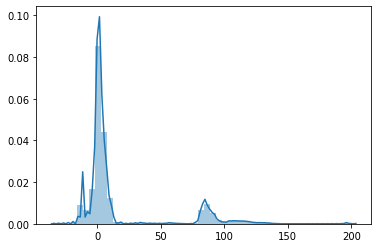

In [5]:
import seaborn as sns
sns.distplot(pre)